In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from model import ode_y, ode_y_jump_approach_one_boundary, uncertainty_decomposition
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [65]:
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# Solve for value function, baseline case
model_i, model = solve_value_function(ξ_w, ξ_p, ξ_a, damage_setting)

n_damage = len(damage_setting['πd_o'])
y_bar = model['y_grid'][-1]
y_grid_short = model['y_grid']
y_grid_long = model_i[0]['y_grid']

g_previous = model['g']

# Simulation
ems_previous, _, _, _ = simulation(model['y_grid'], model['e_tilde'], model['h'], model['g'],
                            θ=np.mean(model['θ']), y_start=1., T=100)

Converged. Total iteration 5000: LHS Error: 2.64627053017108e-06; RHS Error 0.00013138781940240374
Converged. Total iteration 5000: LHS Error: 8.207149745720343e-06; RHS Error 0.000437112470925205
Converged. Total iteration 331: LHS Error: 9.900674768914542e-09; RHS Error 0.0022283118184663175
Converged. Total iteration 5000: LHS Error: 1.2698912591480038e-05; RHS Error 0.0008060769039047663


In [66]:
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# Solve for value function, baseline case
model_i, model = solve_value_function(ξ_w, ξ_p, ξ_a, damage_setting, y_bar=1.9)

n_damage = len(damage_setting['πd_o'])
y_bar = model['y_grid'][-1]
y_grid_short = model['y_grid']
y_grid_long = model_i[0]['y_grid']

g_previous_1p1_1p9 = model['g']

# Simulation
ems_previous_1p1_1p9, _, _, _ = simulation(model['y_grid'], model['e_tilde'], model['h'], model['g'],
                            θ=np.mean(model['θ']), y_start=1.1, T=100)

Converged. Total iteration 5000: LHS Error: 2.64627053017108e-06; RHS Error 0.00013138781940240374
Converged. Total iteration 5000: LHS Error: 6.016913356576836e-06; RHS Error 0.0004314825999426411
Converged. Total iteration 331: LHS Error: 9.915792631431941e-09; RHS Error 0.0020533207293325197
Converged. Total iteration 5000: LHS Error: 7.1163125452411435e-06; RHS Error 0.0008067482279383066


In [2]:
# Simulate capital process
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [117]:
ems_new = np.load('ems_new.npy')
g_new = np.load('g_new.npy')
y_new = np.load('y_grid_new.npy')
y_previous = np.arange(0., 2.02, .02)
y_previous_1p1_1p9 = np.arange(0., 1.92, .02)

scc_new = η*(0.025)*Kt/((1.-η)*ems_new) * 1000
scc_previous = η*(0.025)*Kt/((1.-η)*ems_previous) * 1000
scc_previous_1p1_1p9 = η*(0.025)*Kt/((1.-η)*ems_previous_1p1_1p9) * 1000

πd_new = (g_new.T*damage_setting['πd_o']).T/np.average(g_new, weights=damage_setting['πd_o'], axis=0)
πd_previous = (g_previous.T*damage_setting['πd_o']).T/np.average(g_previous, weights=damage_setting['πd_o'], axis=0)
πd_previous_1p1_1p9 = (g_previous_1p1_1p9.T*damage_setting['πd_o']).T/np.average(g_previous_1p1_1p9, weights=damage_setting['πd_o'], axis=0)

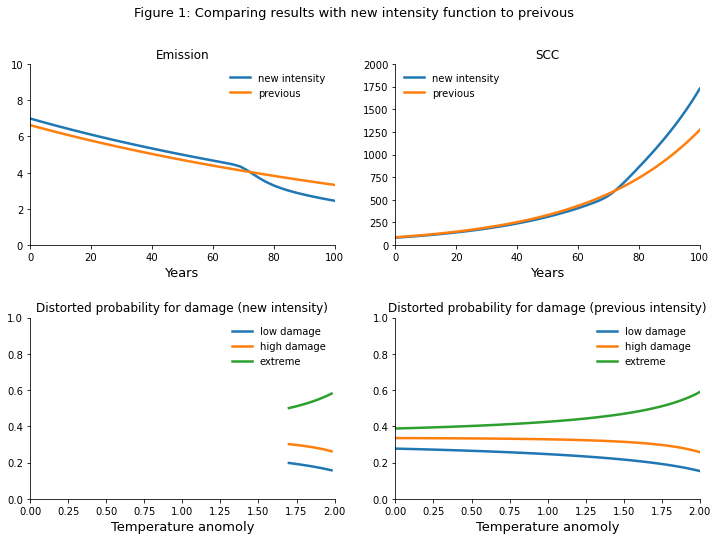

In [129]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle('Figure 1: Comparing results with new intensity function to preivous', fontsize=13)
plt.subplots_adjust(hspace = 0.4)

axs[0, 0].plot(ems_new, label='new intensity', linewidth=2.5)
axs[0, 0].plot(ems_previous, label=r'previous', linewidth=2.5)
axs[0, 0].set_xlabel('Years', fontsize=13)
axs[0, 0].legend(frameon=False)
axs[0, 0].set_ylim(0, 10)
axs[0, 0].set_xlim(0, 100)
axs[0, 0].set_title('Emission')

axs[0, 1].plot(scc_new, label='new intensity', linewidth=2.5)
axs[0, 1].plot(scc_previous, label='previous', linewidth=2.5)
axs[0, 1].set_xlabel('Years', fontsize=13)
axs[0, 1].legend(frameon=False)
axs[0, 1].set_ylim(0, 2000)
axs[0, 1].set_xlim(0, 100)
axs[0, 1].set_title('SCC')

axs[1, 0].plot(y_new[85:], πd_new[0][85:], label='low damage', linewidth=2.5)
axs[1, 0].plot(y_new[85:], πd_new[1][85:], label='high damage', linewidth=2.5)
axs[1, 0].plot(y_new[85:], πd_new[2][85:], label='extreme', linewidth=2.5)
axs[1, 0].set_xlabel('Temperature anomoly', fontsize=13)
axs[1, 0].legend(frameon=False)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(0, 2)
axs[1, 0].set_title('Distorted probability for damage (new intensity)')

axs[1, 1].plot(y_previous, πd_previous[0], label='low damage', linewidth=2.5)
axs[1, 1].plot(y_previous, πd_previous[1], label='high damage', linewidth=2.5)
axs[1, 1].plot(y_previous, πd_previous[2], label='extreme', linewidth=2.5)
axs[1, 1].set_xlabel('Temperature anomoly', fontsize=13)
axs[1, 1].legend(frameon=False)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xlim(0, 2)
axs[1, 1].set_title('Distorted probability for damage (previous intensity)')

fig.savefig('../plots/fig_1.pdf')

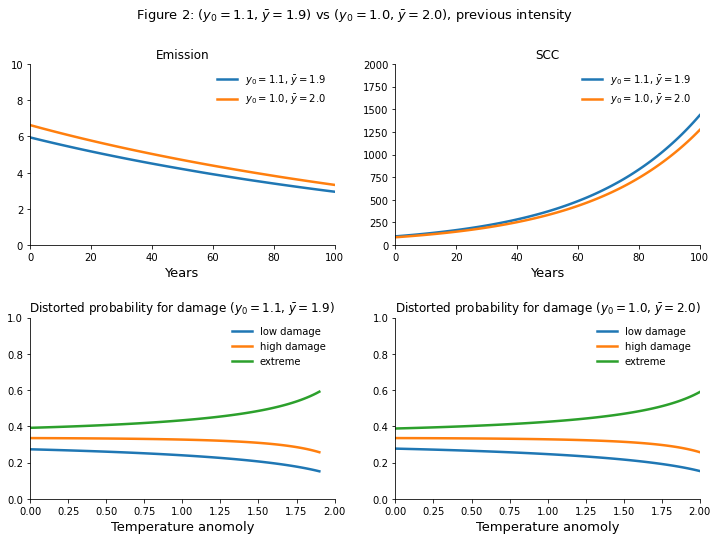

In [130]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle(r'Figure 2: ($y_0=1.1$, $\bar{y}=1.9$) vs ($y_0=1.0$, $\bar{y}=2.0$), previous intensity', fontsize=13)
plt.subplots_adjust(hspace = 0.4)

axs[0, 0].plot(ems_previous_1p1_1p9, label=r'$y_0=1.1$, $\bar{y}=1.9$', linewidth=2.5)
axs[0, 0].plot(ems_previous, label=r'$y_0=1.0$, $\bar{y}=2.0$', linewidth=2.5)
axs[0, 0].set_xlabel('Years', fontsize=13)
axs[0, 0].legend(frameon=False)
axs[0, 0].set_ylim(0, 10)
axs[0, 0].set_xlim(0, 100)
axs[0, 0].set_title('Emission')

axs[0, 1].plot(scc_previous_1p1_1p9, label=r'$y_0=1.1$, $\bar{y}=1.9$', linewidth=2.5)
axs[0, 1].plot(scc_previous, label=r'$y_0=1.0$, $\bar{y}=2.0$', linewidth=2.5)
axs[0, 1].set_xlabel('Years', fontsize=13)
axs[0, 1].legend(frameon=False)
axs[0, 1].set_ylim(0, 2000)
axs[0, 1].set_xlim(0, 100)
axs[0, 1].set_title('SCC')


axs[1, 0].plot(y_previous_1p1_1p9, πd_previous_1p1_1p9[0], label='low damage', linewidth=2.5)
axs[1, 0].plot(y_previous_1p1_1p9, πd_previous_1p1_1p9[1], label='high damage', linewidth=2.5)
axs[1, 0].plot(y_previous_1p1_1p9, πd_previous_1p1_1p9[2], label='extreme', linewidth=2.5)
axs[1, 0].set_xlabel('Temperature anomoly', fontsize=13)
axs[1, 0].legend(frameon=False)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(0, 2)
axs[1, 0].set_title(r'Distorted probability for damage ($y_0=1.1$, $\bar{y}=1.9$)')

axs[1, 1].plot(y_previous, πd_previous[0], label='low damage', linewidth=2.5)
axs[1, 1].plot(y_previous, πd_previous[1], label='high damage', linewidth=2.5)
axs[1, 1].plot(y_previous, πd_previous[2], label='extreme', linewidth=2.5)
axs[1, 1].set_xlabel('Temperature anomoly', fontsize=13)
axs[1, 1].legend(frameon=False)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xlim(0, 2)
axs[1, 1].set_title(r'Distorted probability for damage ($y_0=1.0$, $\bar{y}=2.0$)')

fig.savefig('../plots/fig_2.pdf')